### Derivation of the Lipschitz Constant

$$
\left| \nabla_j f(w + t e_j) - \nabla_j f(w) \right| \leq L_j |t| \quad \forall w, t
$$

If such $L_j$ exists, we can choose the step size $\alpha = \frac{1}{L_j}$ and guarantee that the function value will decrease (see Theorem 1 in Wright's paper).

For the function:

$$
f(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + e^{-y_i x_i^\top w})
$$

the gradient with respect to $w_j$ is:

$$
\nabla_j f(w) = \frac{1}{n} \sum_{i=1}^n (\sigma(z_i) - y_i) \cdot x_{ij}, \quad \text{where } z_i = x_i^\top w
$$

and $\sigma(z)$ is the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The derivative of the gradient with respect to the same coordinate $w_j$ (i.e., the second derivative of $f$ with respect to $w_j$) is:

$$
\frac{\partial}{\partial w_j} \nabla_j f(w) = \frac{1}{n} \sum_{i=1}^n \sigma(z_i)(1 - \sigma(z_i)) \cdot x_{ij}^2
$$

Where:

$$
\sigma(z)(1 - \sigma(z)) \leq \frac{1}{4} \quad \text{for any } z
$$

(the maximum is achieved when $\sigma(z) = 0.5$).

From the above it follows:

$$
\left| \frac{\partial}{\partial w_j} \nabla_j f(w) \right|
\leq \frac{1}{n} \sum_{i=1}^n \frac{1}{4} x_{ij}^2
= \frac{1}{4} \cdot \frac{1}{n} \sum_{i=1}^n x_{ij}^2 = L_j
$$

This means that the gradient with respect to $w_j$ does not change faster than $L_j$ times the distance along that coordinate.


## Single epoch algorithm 

We compute $t$ and perform the lookahead:

$$
v = w + \frac{t_{\text{prev}} - 1}{t} (w - w_{\text{prev}})
$$

We update each coordinate in random order.

In the residual, we compute:

$$
\sigma(Xv) - y
$$

Gradient of coordinate $j$: $g_j$.

$$
g_j = \frac{1}{n} \sum_{i=1}^n (\sigma(z_i) - y_i) \cdot x_{ij}
$$

Step:

$$
\alpha = \frac{1}{L_j}
$$

Soft-threshold -> $w_{\text{new},j}$.

If the value changed (delta ≠ 0), we update $v[j]$ and correct the logits:

```python
z += delta * X[:, j]
```

We finish the epoch with

- w_prev <- w  
- w <- v  
- t_prev <- t

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from cd import cd_logreg_l1, acd_logreg_l1

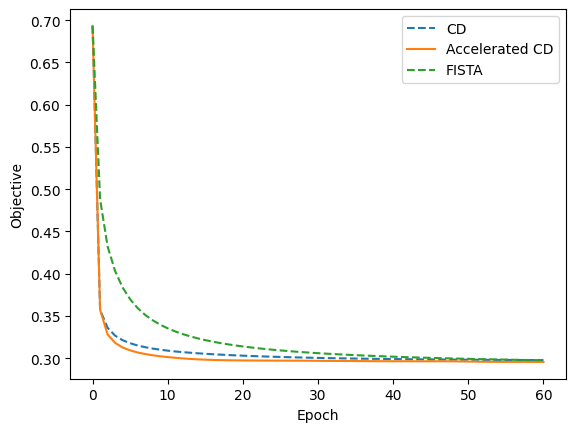

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from fista import fista_logreg_l1
from cd import cd_logreg_l1, acd_logreg_l1

data = load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target.astype(float)

epochs = 60
lam = 1e-3
w, hist_acc   = acd_logreg_l1(X, y, lambd=lam, epochs=epochs, seed=42)
w, hist_plain = cd_logreg_l1(X, y, lambd=lam, epochs=epochs, seed=42)
w, hist_fista = fista_logreg_l1(X, y, lambd=lam, epochs=epochs)

plt.plot(hist_plain, label="CD", linestyle="--")
plt.plot(hist_acc,   label="Accelerated CD")
plt.plot(hist_fista,   label="FISTA", linestyle="--")

plt.xlabel("Epoch"); plt.ylabel("Objective"); plt.legend(); plt.show()


Synthetic datasets

Set  1:  CD MSE=0.0930   ACD MSE=0.0930
Set  2:  CD MSE=0.1097   ACD MSE=0.1097
Set  3:  CD MSE=0.1148   ACD MSE=0.1148
Set  4:  CD MSE=0.0052   ACD MSE=0.0052


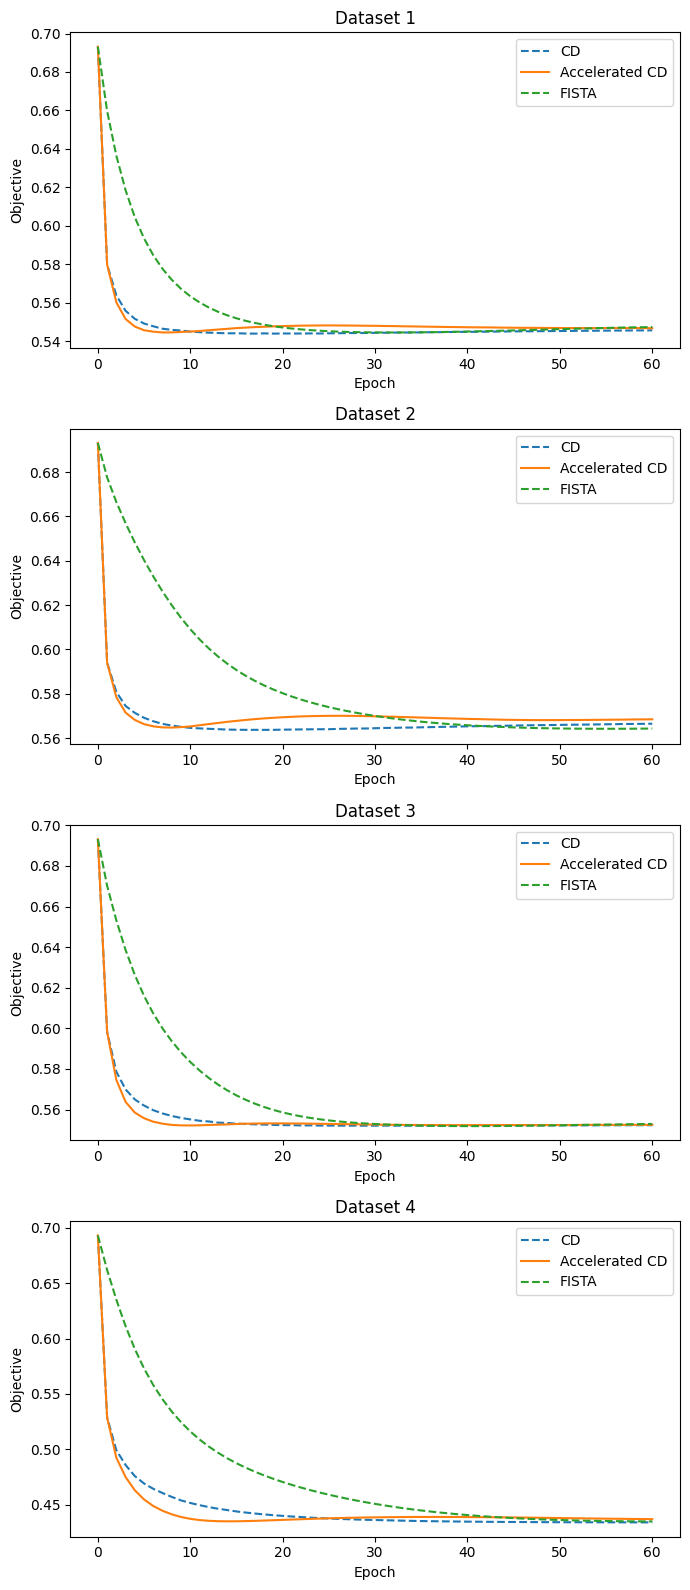

In [11]:
from sklearn.datasets import make_classification
from utils import sigmoid
configs = [
    dict(n_samples=1000, n_features=500,  n_informative=20,  n_redundant=50,
         flip_y=0.15, class_sep=0.5, random_state=0),
    dict(n_samples=1500, n_features=1000, n_informative=30,  n_redundant=300,
         flip_y=0.25, class_sep=0.3, random_state=1),
    dict(n_samples= 800, n_features=400,  n_informative=10,  n_redundant=50,
         n_clusters_per_class=2, flip_y=0.30, class_sep=0.2, random_state=2),
    dict(n_samples= 450, n_features=400,  n_informative=10,  n_redundant=50,
         n_clusters_per_class=2, flip_y=0.40, class_sep=0.1, random_state=3)
]
from sklearn.datasets import make_classification

lam, epochs = 5e-4, 60
fig, axes = plt.subplots(len(configs), 1, figsize=(7, 4*len(configs)))

for idx, cfg in enumerate(configs):
    X, y = make_classification(**cfg)
    X = StandardScaler().fit_transform(X); y = y.astype(float)

    w, hist_plain = cd_logreg_l1 (X, y, lam, epochs, seed=idx)
    w, hist_acc   = acd_logreg_l1(X, y, lam, epochs, seed=idx)
    w, hist_fista = fista_logreg_l1(X, y, lambd=lam, epochs=epochs)


    mse_plain = mean_squared_error(y, sigmoid(X @ w))
    mse_acc   = mean_squared_error(y, sigmoid(X @ w))
    print(f"Set {idx+1:>2}:  CD MSE={mse_plain:.4f}   ACD MSE={mse_acc:.4f}")

    ax = axes[idx]
    ax.plot(hist_plain, label="CD", linestyle="--")
    ax.plot(hist_acc,   label="Accelerated CD")
    ax.plot(hist_fista,   label="FISTA", linestyle="--")
    ax.set_title(f"Dataset {idx+1}")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Objective")
    ax.legend()

plt.tight_layout()
plt.show()